## Trying out a linear model: 

Author: Alexandru Papiu ([@apapiu](https://twitter.com/apapiu), [GitHub](https://github.com/apapiu))
 
If you use parts of this notebook in your own scripts, please give some sort of credit (for example link back to this). Thanks!


There have been a few [great](https://www.kaggle.com/comartel/house-prices-advanced-regression-techniques/house-price-xgboost-starter/run/348739)  [scripts](https://www.kaggle.com/zoupet/house-prices-advanced-regression-techniques/xgboost-10-kfolds-with-scikit-learn/run/357561) on [xgboost](https://www.kaggle.com/tadepalli/house-prices-advanced-regression-techniques/xgboost-with-n-trees-autostop-0-12638/run/353049) already so I'd figured I'd try something simpler: a regularized linear regression model. Surprisingly it does really well with very little feature engineering. The key point is to to log_transform the numeric variables since most of them are skewed.

In [105]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr

from tabulate import tabulate

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [106]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [107]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [108]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))
all_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


###Data preprocessing: 
We're not going to do anything fancy here: 
 
- First I'll transform the skewed numeric features by taking log(feature + 1) - this will make the features more normal    
- Create Dummy variables for the categorical features    
- Replace the numeric missing values (NaN's) with the mean of their respective columns

In [109]:
#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])
all_data[skewed_feats].head()

,MSSubClass,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,GrLivArea,BsmtHalfBath,KitchenAbvGr,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
0,4.110874,4.189655,9.042040,5.283204,6.561031,0.0,5.017280,6.753438,6.753438,6.751101,...,7.444833,0.000000,0.693147,0.000000,4.127134,0.000000,0.0,0.0,0.0,0.0
1,3.044522,4.394449,9.169623,0.000000,6.886532,0.0,5.652489,7.141245,7.141245,0.000000,...,7.141245,0.693147,0.693147,5.700444,0.000000,0.000000,0.0,0.0,0.0,0.0
2,4.110874,4.234107,9.328212,5.093750,6.188264,0.0,6.075346,6.825460,6.825460,6.765039,...,7.488294,0.000000,0.693147,0.000000,3.761200,0.000000,0.0,0.0,0.0,0.0
3,4.262680,4.110874,9.164401,0.000000,5.379897,0.0,6.293419,6.629363,6.869014,6.629363,...,7.448916,0.000000,0.693147,0.000000,3.583519,5.609472,0.0,0.0,0.0,0.0
4,4.110874,4.442651,9.565284,5.860786,6.486161,0.0,6.196444,7.044033,7.044033,6.960348,...,7.695758,0.000000,0.693147,5.262690,4.442651,0.000000,0.0,0.0,0.0,0.0


In [110]:
from sklearn.linear_model import LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

def r2_cv(model):
    return cross_val_score(model, X_train, y, scoring="r2", cv = 5)

In [111]:
def add_residential(data):
    copy = data.copy()
    copy["enc_quiet_residential"] = copy["MSZoning"].apply(lambda x:1 if x == "RL" else 0)
    return copy

In [112]:
table = []
headers = ["type", "R squared", "RMSE"]

my_data = all_data.select_dtypes(include=[np.number])
my_data = my_data.fillna(my_data.mean())
X_train = my_data[:train.shape[0]]
y = train.SalePrice

model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)
table.append(["All numeric", r2_cv(model_lasso).mean(),  rmse_cv(model_lasso).mean()])

my_data = add_residential(all_data)
my_data = all_data.select_dtypes(include=[np.number])
my_data = my_data.fillna(my_data.mean())
X_train = my_data[:train.shape[0]]
y = train.SalePrice

model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)
table.append(["Numeric + res", r2_cv(model_lasso).mean(),  rmse_cv(model_lasso).mean()])

my_data = all_data.select_dtypes(include=[np.number])
my_data = my_data.drop(["OverallQual"], axis=1)
my_data = my_data.fillna(my_data.mean())
X_train = my_data[:train.shape[0]]
y = train.SalePrice

model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)
table.append(["Numeric - OverallQual", r2_cv(model_lasso).mean(),  rmse_cv(model_lasso).mean()])

my_data = pd.get_dummies(all_data)
my_data = my_data.fillna(my_data.mean())
X_train = my_data[:train.shape[0]]
y = train.SalePrice

model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)
table.append(["Numeric + features", r2_cv(model_lasso).mean(),  rmse_cv(model_lasso).mean()])

print(tabulate(table, headers, tablefmt="plain"))

type                     R squared      RMSE
All numeric               0.875358  0.13999
Numeric + res             0.875358  0.13999
Numeric - OverallQual     0.850025  0.153573
Numeric + features        0.903287  0.123144


###Models

Now we are going to use regularized linear regression models from the scikit learn module. I'm going to try both l_1(Lasso) and l_2(Ridge) regularization. I'll also define a function that returns the cross-validation rmse error so we can evaluate our models and pick the best tuning par

Nice! The lasso performs even better so we'll just use this one to predict on the test set. Another neat thing about the Lasso is that it does feature selection for you - setting coefficients of features it deems unimportant to zero. Let's take a look at the coefficients:

In [113]:
def enc_condition(x): return 1 if x == 'Partial' else 0


def foundation(x): return 1 if x == 'PConc' else 0


def misc_feature(x): return 1 if x == 'TenC' else 0


def fireplace(x): return 1 if x == "Ex" else 0


def exterior(x):
    if x == "Ex":
        return 5
    elif x == "Gd":
        return 4
    elif x == "TA":
        return 3
    elif x == "Fa":
        return 2
    else:
        return 1

def residential(x): return 1 if x == "RL" else 0

def add_features(data):
    new_data = data.copy()
    new_data['enc_street'] = pd.get_dummies(new_data.Street, drop_first=True).astype(np.number)
    new_data['enc_condition'] = new_data.SaleCondition.apply(enc_condition).astype(np.number)
    new_data['enc_foundation'] = new_data.Foundation.apply(foundation).astype(np.number)
    new_data['enc_misc_feature'] = new_data.MiscFeature.apply(misc_feature).astype(np.number)
    new_data['enc_central_air'] = pd.get_dummies(new_data.CentralAir, drop_first=True).astype(np.number)
    new_data['enc_fireplace'] = new_data.FireplaceQu.apply(misc_feature).astype(np.number)
    new_data['enc_exterior'] = new_data.ExterCond.apply(exterior).astype(np.number)
    new_data["enc_quiet_residential"] = new_data["MSZoning"].apply(residential)
    return new_data

In [114]:
def add_conditions(data):
    copy = data.copy()
    copy["enc_artery"] = (copy["Condition1"] == "Artery") | (copy["Condition2"] == "Artery")
    copy["enc_feeder"] = (copy["Condition1"] == "Feedr") | (copy["Condition2"] == "Feedr")
    copy["enc_normal"] = (copy["Condition1"] == "Norm") | (copy["Condition2"] == "Norm")
    copy["enc_RRNn"] = (copy["Condition1"] == "RRNn") | (copy["Condition2"] == "RRNn")
    copy["enc_RRAn"] = (copy["Condition1"] == "RRAn") | (copy["Condition2"] == "RRAn")
    copy["enc_PosN"] = (copy["Condition1"] == "PosN") | (copy["Condition2"] == "PosN")
    copy["enc_PosA"] = (copy["Condition1"] == "PosA") | (copy["Condition2"] == "PosA")
    copy["enc_RRNe"] = (copy["Condition1"] == "RRNe") | (copy["Condition2"] == "RRNe")
    copy["enc_RRAe"] = (copy["Condition1"] == "RRAe") | (copy["Condition2"] == "RRAe")
    return copy

def add_exterior(data):
    copy = data.copy()
    copy["enc_AsbShng"] = (copy["Exterior1st"] == "AsbShng") | (copy["Exterior2nd"] == "AsbShng")
    copy["enc_AsphShn"] = (copy["Exterior1st"] == "AsphShn") | (copy["Exterior2nd"] == "AsphShn")
    copy["enc_BrkComm"] = (copy["Exterior1st"] == "BrkComm") | (copy["Exterior2nd"] == "BrkComm")
    copy["enc_BrkFace"] = (copy["Exterior1st"] == "BrkFace") | (copy["Exterior2nd"] == "BrkFace")
    copy["enc_CBlock"] = (copy["Exterior1st"] == "CBlock") | (copy["Exterior2nd"] == "CBlock")
    copy["enc_CemntBd"] = (copy["Exterior1st"] == "CemntBd") | (copy["Exterior2nd"] == "CemntBd")    
    copy["enc_HdBoard"] = (copy["Exterior1st"] == "HdBoard") | (copy["Exterior2nd"] == "HdBoard")
    copy["enc_ImStucc"] = (copy["Exterior1st"] == "ImStucc") | (copy["Exterior2nd"] == "ImStucc")    
    copy["enc_MetalSd"] = (copy["Exterior1st"] == "MetalSd") | (copy["Exterior2nd"] == "MetalSd")
    copy["enc_Other"] = (copy["Exterior1st"] == "Other") | (copy["Exterior2nd"] == "Other")
    copy["enc_Plywood"] = (copy["Exterior1st"] == "Plywood") | (copy["Exterior2nd"] == "Plywood")
    copy["enc_PreCast"] = (copy["Exterior1st"] == "PreCast") | (copy["Exterior2nd"] == "PreCast")
    copy["enc_Stone"] = (copy["Exterior1st"] == "Stone") | (copy["Exterior2nd"] == "Stone")
    copy["enc_Stucco"] = (copy["Exterior1st"] == "Stucco") | (copy["Exterior2nd"] == "Stucco")
    copy["enc_VinylSd"] = (copy["Exterior1st"] == "VinylSd") | (copy["Exterior2nd"] == "VinylSd")
    copy["enc_WdSdng"] = (copy["Exterior1st"] == "Wd Sdng") | (copy["Exterior2nd"] == "Wd Sdng")
    copy["enc_WdShing"] = (copy["Exterior1st"] == "WdShing") | (copy["Exterior2nd"] == "WdShing")
    return copy

def add_utilities(data):
    copy = data.copy()
    copy["enc_has_electricity"] = (copy["Utilities"] == "AllPub") | (copy["Utilities"] == "NoSewr") | \
                                  (copy["Utilities"] == "NoSeWa") | (copy["Utilities"] == "ELO")
    copy["enc_has_gas"] = (copy["Utilities"] == "AllPub") | (copy["Utilities"] == "NoSewr") | \
                          (copy["Utilities"] == "NoSeWa") 
    copy["enc_has_water"] = (copy["Utilities"] == "AllPub") | (copy["Utilities"] == "NoSewr")        
    return copy

In [115]:
locations = { "Blmngtn": {"income": 95256, "tax": 3742, "schools": "Average", "numberSchools": 4}, 
  "StoneBr": {"income": 95256, "tax": 4369, "schools": "Average", "numberSchools": 4},
  "Crawfor": {"income": 118304, "tax": 2490, "schools": "Average", "numberSchools": 8},
  "NridgHt": {"income": 95256, "tax": 5478, "schools": "Average", "numberSchools": 4},
  "BrDale": {"income": 45588, "tax": 1785, "schools": "Average", "numberSchools": 8},
  "Somerst": {"income": 84600, "tax": 2314, "schools": "Average", "numberSchools": 8},
  "Blueste": {"income": 46417, "tax": 3709, "schools": "Average", "numberSchools": 8},
  "BrkSide": {"income": 65263, "tax": 2078, "schools": "Average", "numberSchools": 8},
  "Edwards": {"income": 36689, "tax": 2033, "schools": "Average", "numberSchools": 8},
  "OldTown": {"income": 37708, "tax": 2342, "schools": "Average", "numberSchools": 8},
  "NoRidge": {"income": 88438, "tax": 2342, "schools": "Average", "numberSchools": 8},
  "ClearCr": {"income": 94043, "tax": 5741, "schools": "Average", "numberSchools": 8},
  "CollgCr": {"income": 66875, "tax": 2616, "schools": "Average", "numberSchools": 8},
  "Gilbert": {"income": 95256, "tax": 3742, "schools": "Average", "numberSchools": 4}, 
  "Veenker": {"income": 84600, "tax": 3667, "schools": "Average", "numberSchools": 4}, 
  "Timber": {"income": 61100, "tax": 5043, "schools": "Average", "numberSchools": 4}, 
  "Sawyer": {"income": 69067, "tax": 2471, "schools": "Average", "numberSchools": 4}, 
  "SawyerW": {"income": 62446, "tax": 4034, "schools": "Average", "numberSchools": 4}, 
  "SWISU": {"income": 46417, "tax": 3709, "schools": "Average", "numberSchools": 4}, 
  "NPkVill": {"income": 41364, "tax": 2168, "schools": "Average", "numberSchools": 4}, 
  "NWAmes": {"income": 84100, "tax": 3275, "schools": "Average", "numberSchools": 4}, 
  "NAmes": {"income": 45588, "tax": 1913, "schools": "Average", "numberSchools": 4}, 
  "MeadowV": {"income": 53962, "tax": 1521, "schools": "Average", "numberSchools": 4}, 
  "Mitchel": {"income": 53962, "tax": 2035, "schools": "Average", "numberSchools": 4}, 
  "IDOTRR": {"income": 21040, "tax": 0, "schools": "Average", "numberSchools": 4}, 
}

# for location in locations:
#     print(location, locations[location]["income"], locations[location]["tax"])
    
def get_income(x):
    return locations[x]["income"]

def get_tax(x):
    return locations[x]["tax"]
    
# print(train["Neighborhood"].apply(get_income))
    
def hydrate_location(data):
    copy = data.copy()
    copy["enc_neighborhood_income"] = train["Neighborhood"].apply(get_income)
#     copy["enc_neighborhood_tax"] = train["Neighborhood"].apply(get_tax)
    return copy

In [116]:
def categorise_overall(data):
    copy = data.copy()
    copy["OverallQual"] = copy["OverallQual"].astype('category', categories = list(range(1, 11)))
    copy["OverallCond"] = copy["OverallCond"].astype('category', categories = list(range(1, 11)))
    return copy

In [117]:
def clean_nulls(data):
    new_data = data.copy()

    new_data["MasVnrType"] = new_data["MasVnrType"].fillna('None')
    new_data["MasVnrArea"] = new_data["MasVnrArea"].fillna(0.0)
    new_data["Alley"] = new_data["Alley"].fillna('None')
    basement_cols = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtFinSF1', 'BsmtFinSF2']
    for col in basement_cols:
        if 'FinSF' not in col:
            new_data[col] = new_data[col].fillna('None')
    new_data["FireplaceQu"] = new_data["FireplaceQu"].fillna('None')
    garage_cols = ['GarageType', 'GarageQual', 'GarageCond', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea']
    for col in garage_cols:
        if new_data[col].dtype == np.object:
            new_data[col] = new_data[col].fillna('None')
        else:
            new_data[col] = new_data[col].fillna(0)
    new_data.Fence = new_data.Fence.fillna("None")
    new_data.MiscFeature = new_data.MiscFeature.fillna("None")

    missing_lot_frontage = new_data['LotFrontage'].isnull()
    new_data['SqrtLotArea'] = np.sqrt(new_data['LotArea'])
    # new_data.LotFrontage[missing_lot_frontage] = new_data.SqrtLotArea[missing_lot_frontage]

    new_data.loc[missing_lot_frontage, "LotFrontage"] = new_data.loc[missing_lot_frontage, "SqrtLotArea"]

    new_data["PoolQC"] = new_data["PoolQC"].fillna('None')
    new_data["Electrical"] = new_data["Electrical"].fillna('SBrkr')
    
    new_data["BsmtFullBath"] = new_data["BsmtFullBath"].fillna(0)
    new_data["BsmtHalfBath"] = new_data["BsmtHalfBath"].fillna(0)
    new_data["TotalBsmtSF"] = new_data["TotalBsmtSF"].fillna(0)
    new_data["BsmtUnfSF"] = new_data["BsmtUnfSF"].fillna(0)
    new_data["BsmtFinSF1"] = new_data["BsmtFinSF1"].fillna(0)
    new_data["BsmtFinSF2"] = new_data["BsmtFinSF2"].fillna(0)
    
    new_data["MSZoning"] = new_data["MSZoning"].fillna(new_data["MSZoning"].value_counts().keys()[0])
    new_data["Utilities"] = new_data["Utilities"].fillna(new_data["Utilities"].value_counts().keys()[0])
    new_data["Exterior1st"] = new_data["Exterior1st"].fillna(new_data["Exterior1st"].value_counts().keys()[0])
    new_data["Exterior2nd"] = new_data["Exterior2nd"].fillna(new_data["Exterior2nd"].value_counts().keys()[0])
    new_data["KitchenQual"] = new_data["KitchenQual"].fillna(new_data["KitchenQual"].value_counts().keys()[0])
    new_data["Functional"] = new_data["Functional"].fillna(new_data["Functional"].value_counts().keys()[0])
    new_data["SaleType"] = new_data["SaleType"].fillna(new_data["SaleType"].value_counts().keys()[0])

    return new_data.drop(["SqrtLotArea"], axis=1)

Numeric + features 0.899848288115 0.125500459672
Lasso picked 113 variables and eliminated the other 171 variables


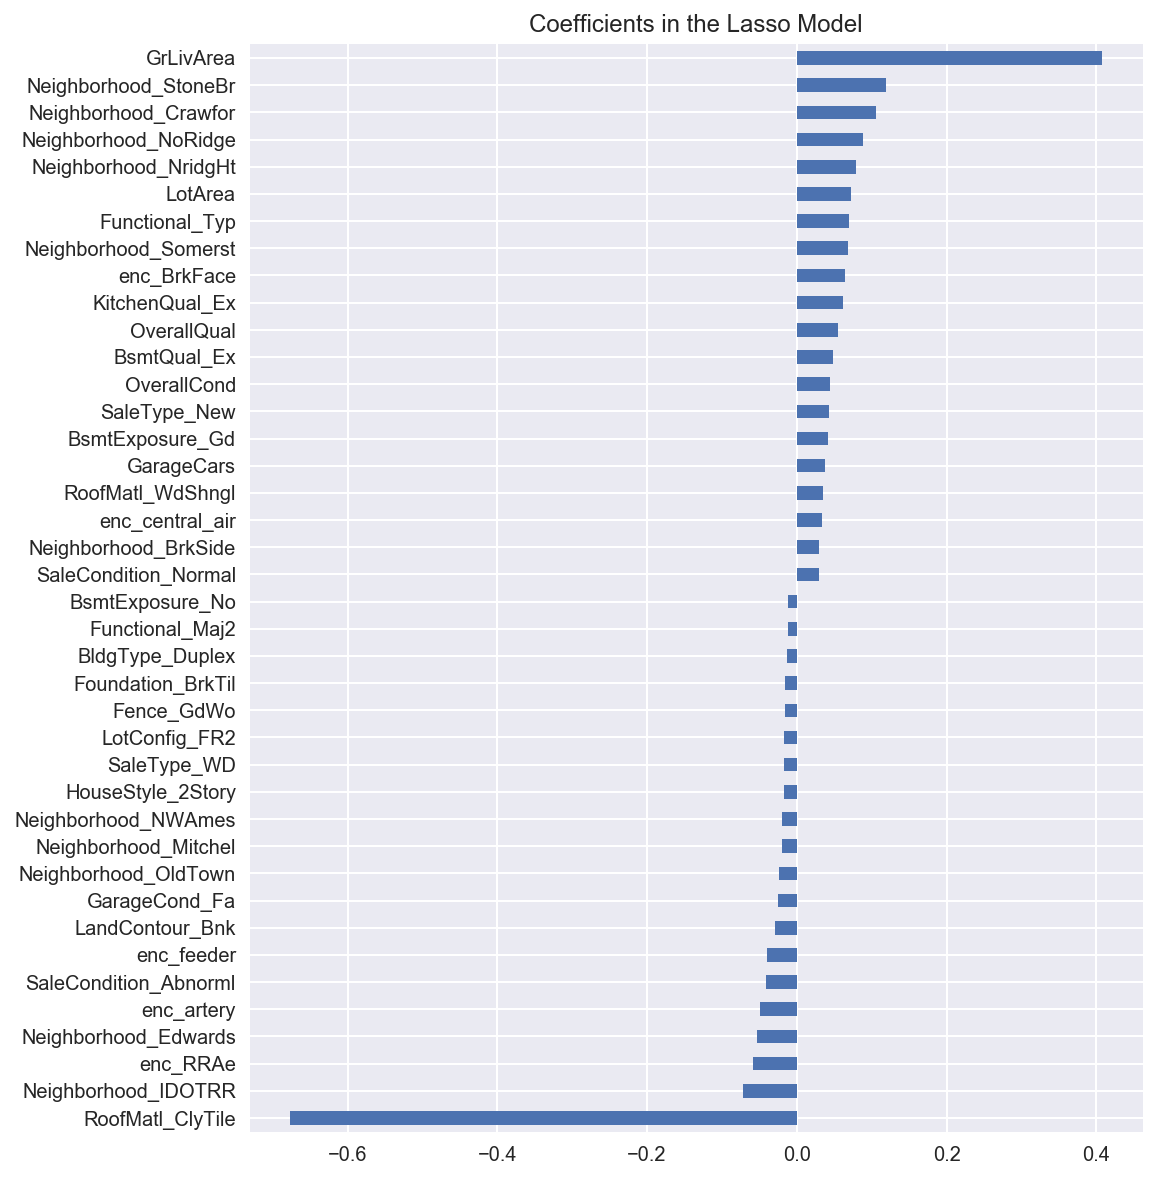

In [118]:
# my_data = hydrate_location(add_conditions(add_features(all_data)))
# excluded = ["Condition2", "Condition1", "MSZoning", "RoofMatl", "Exterior1st"] # 0.11975
# excluded = ["Condition2", "Condition1", "MSZoning", "Exterior1st"] # 0.11912
excluded = ["Condition2", "Condition1", "MSZoning", "Exterior1st", "Exterior2nd", "Utilities"] # 0.11873
my_data = add_utilities(add_exterior(add_conditions(add_features(all_data))))
my_data = clean_nulls(my_data)
my_data = my_data.drop(excluded, axis=1) 
my_data = pd.get_dummies(my_data)
# my_data = my_data.fillna(my_data.mean())

X_train = my_data[:train.shape[0]]
y = train.SalePrice

model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)
print("Numeric + features", r2_cv(model_lasso).mean(),  rmse_cv(model_lasso).mean())

coef = pd.Series(model_lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")
# print(coef.sort_values(ascending=False))

imp_coef = pd.concat([coef.sort_values().head(20), coef.sort_values().tail(20)])

matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

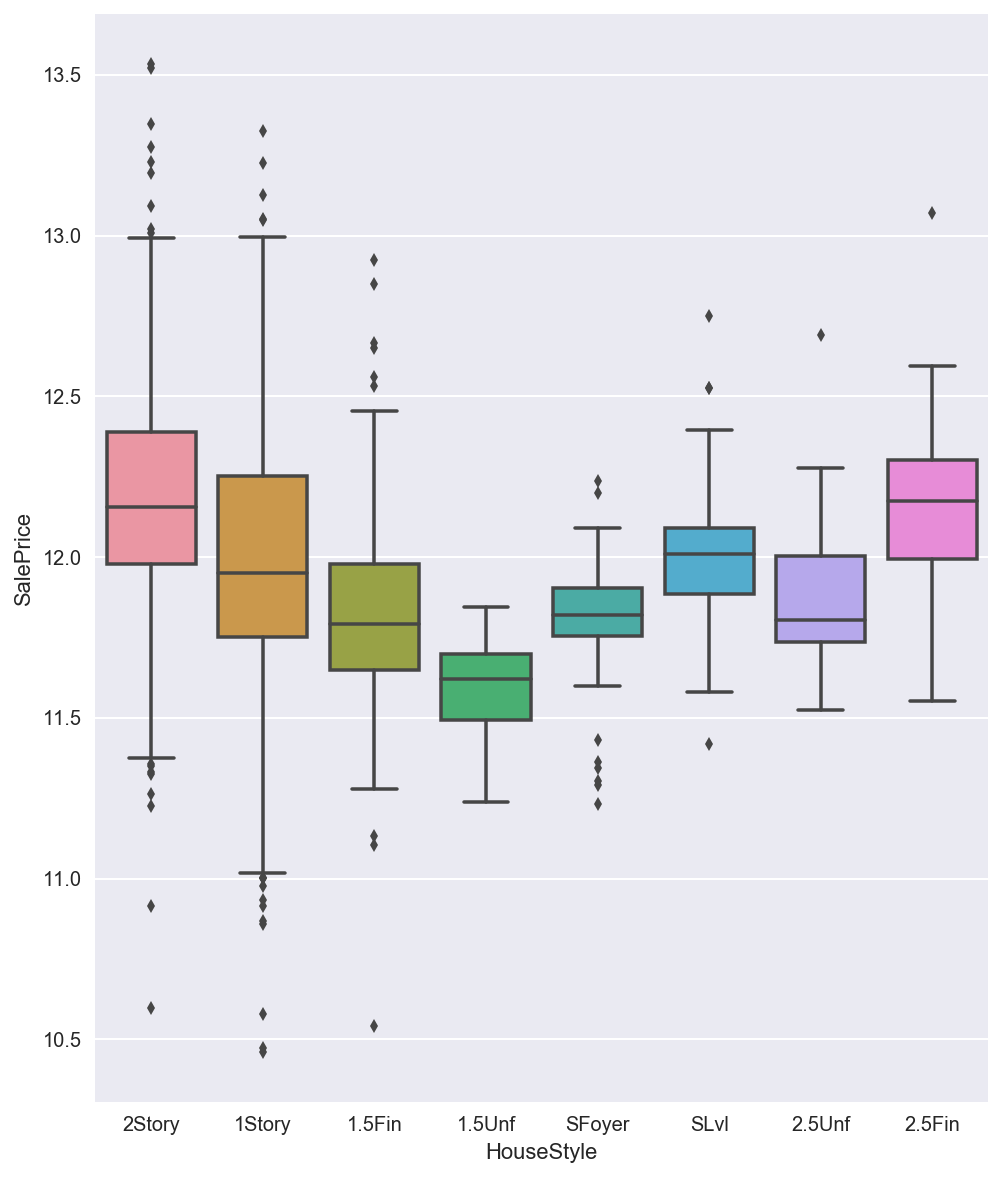

In [49]:
sns.boxplot("HouseStyle","SalePrice",data=train);

In [50]:
train[train["RoofMatl"] == "ClyTile"]
test[test["RoofMatl"] == "ClyTile"]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition


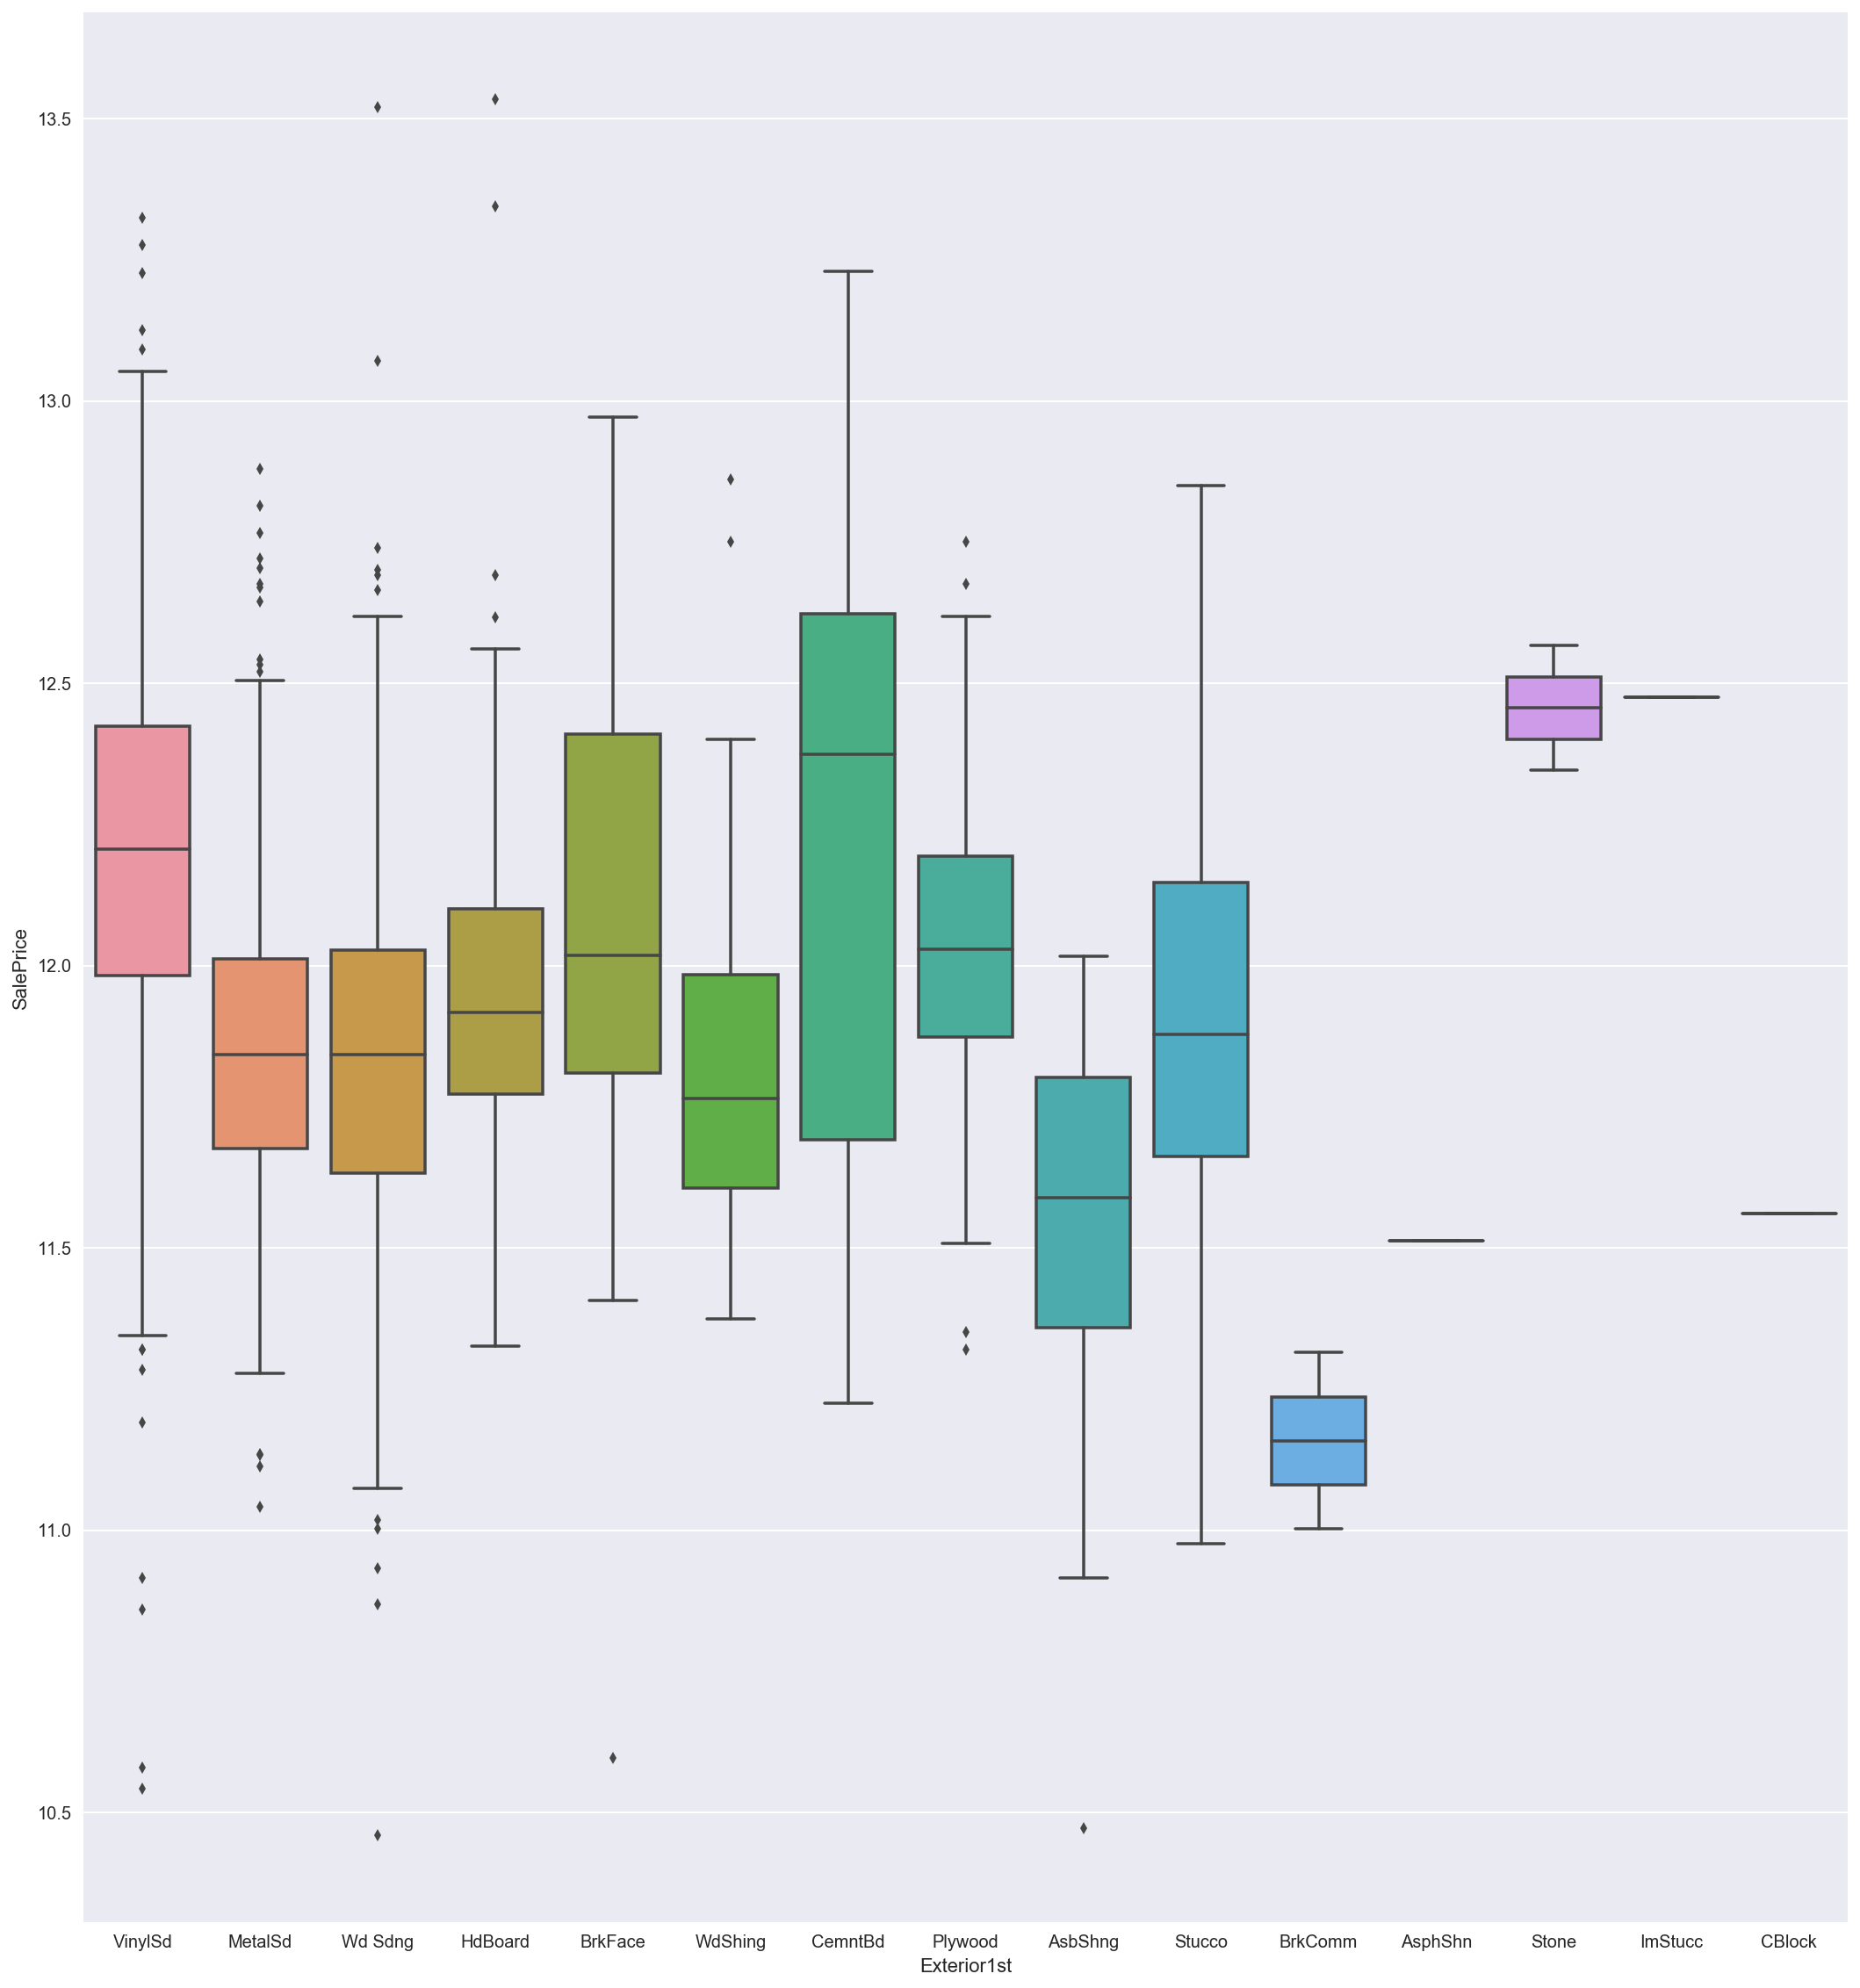

In [51]:
matplotlib.rcParams['figure.figsize'] = (18.0, 20.0)
sns.boxplot("Exterior1st","SalePrice",data=train)

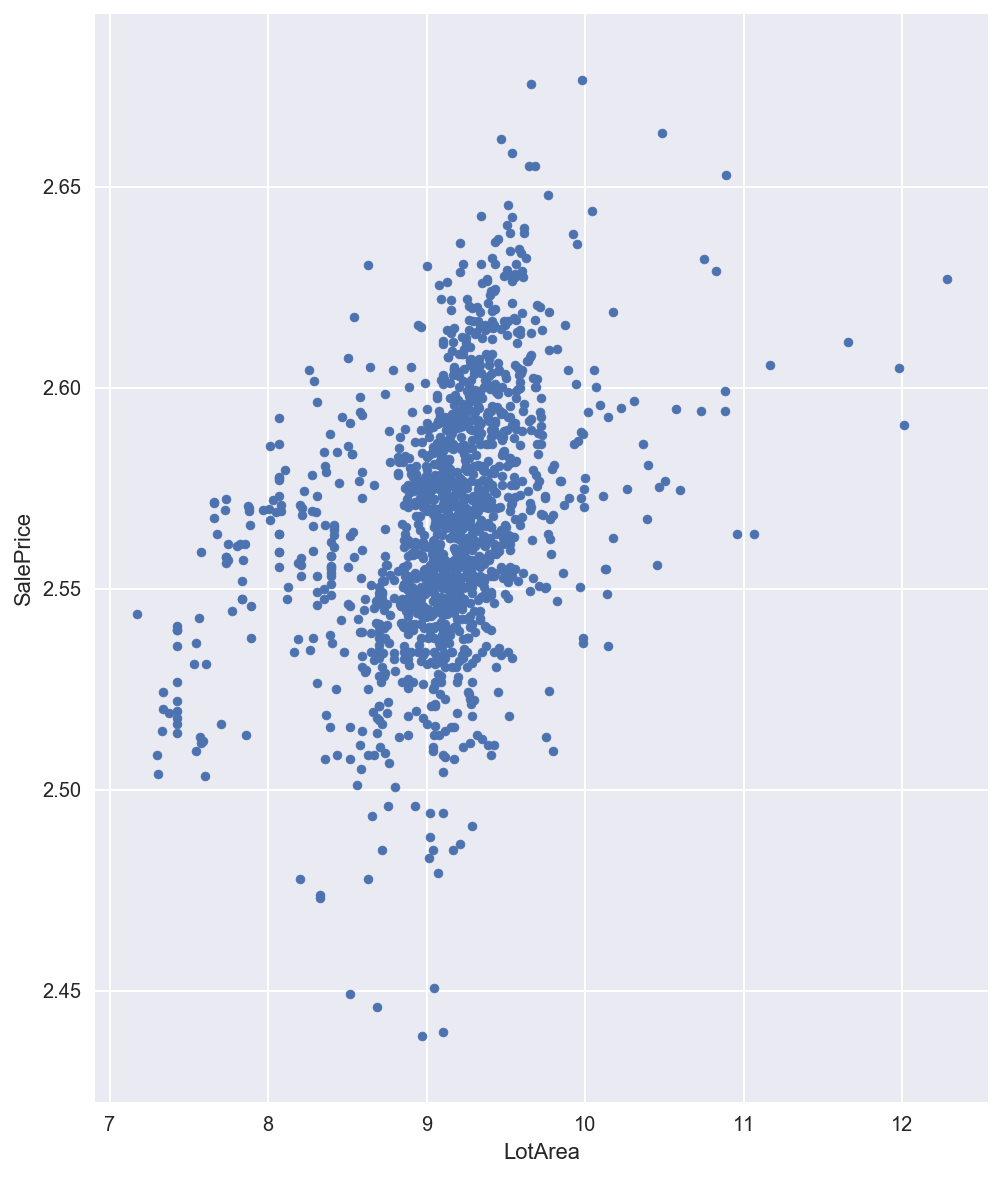

In [86]:
# sns.scatterplot("LotArea","SalePrice",data=train)
copy = train.copy()
copy["LotArea"] = np.log1p(train["LotArea"])
copy.plot(x = "LotArea", y = "SalePrice",kind = "scatter")

Good job Lasso.  One thing to note here however is that the features selected are not necessarily the "correct" ones - especially since there are a lot of collinear features in this dataset. One idea to try here is run Lasso a few times on boostrapped samples and see how stable the feature selection is.

We can also take a look directly at what the most important coefficients are:

The most important positive feature is `GrLivArea` -  the above ground area by area square feet. This definitely sense. Then a few other  location and quality features contributed positively. Some of the negative features make less sense and would be worth looking into more - it seems like they might come from unbalanced categorical variables.

 Also note that unlike the feature importance you'd get from a random forest these are _actual_ coefficients in your model - so you can say precisely why the predicted price is what it is. The only issue here is that we log_transformed both the target and the numeric features so the actual magnitudes are a bit hard to interpret. 

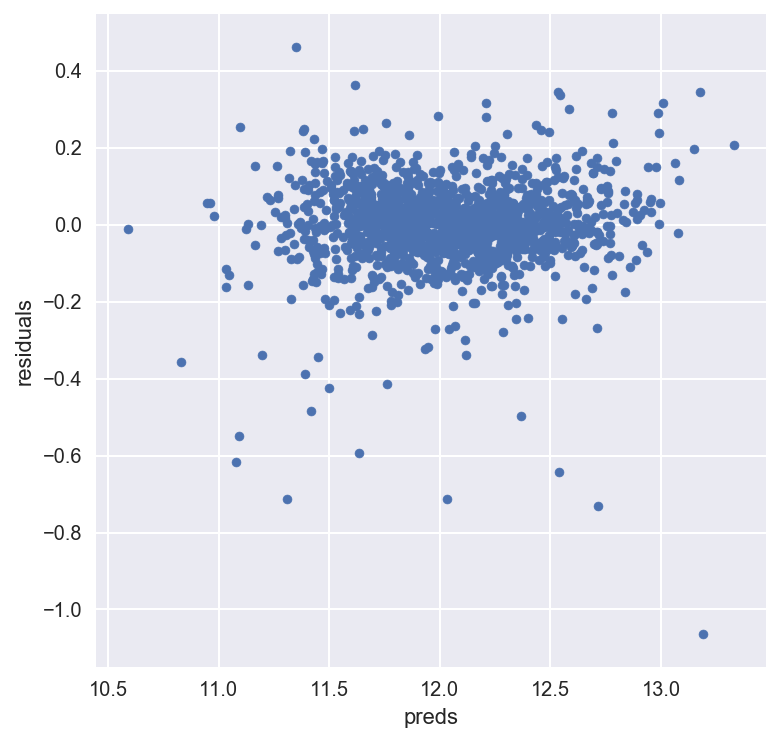

In [52]:
#let's look at the residuals as well:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

The residual plot looks pretty good.To wrap it up let's predict on the test set and submit on the leaderboard:

In [121]:
X_test = my_data[train.shape[0]:]
lasso_preds = np.expm1(model_lasso.predict(X_test))
solution = pd.DataFrame({"id":test.Id, "SalePrice":lasso_preds})
solution.to_csv("lasso_sol.csv", index = False)

### Adding an xgboost model:

Let's add an xgboost model to our linear model to see if we can improve our score:

In [122]:
import xgboost as xgb

In [123]:

dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

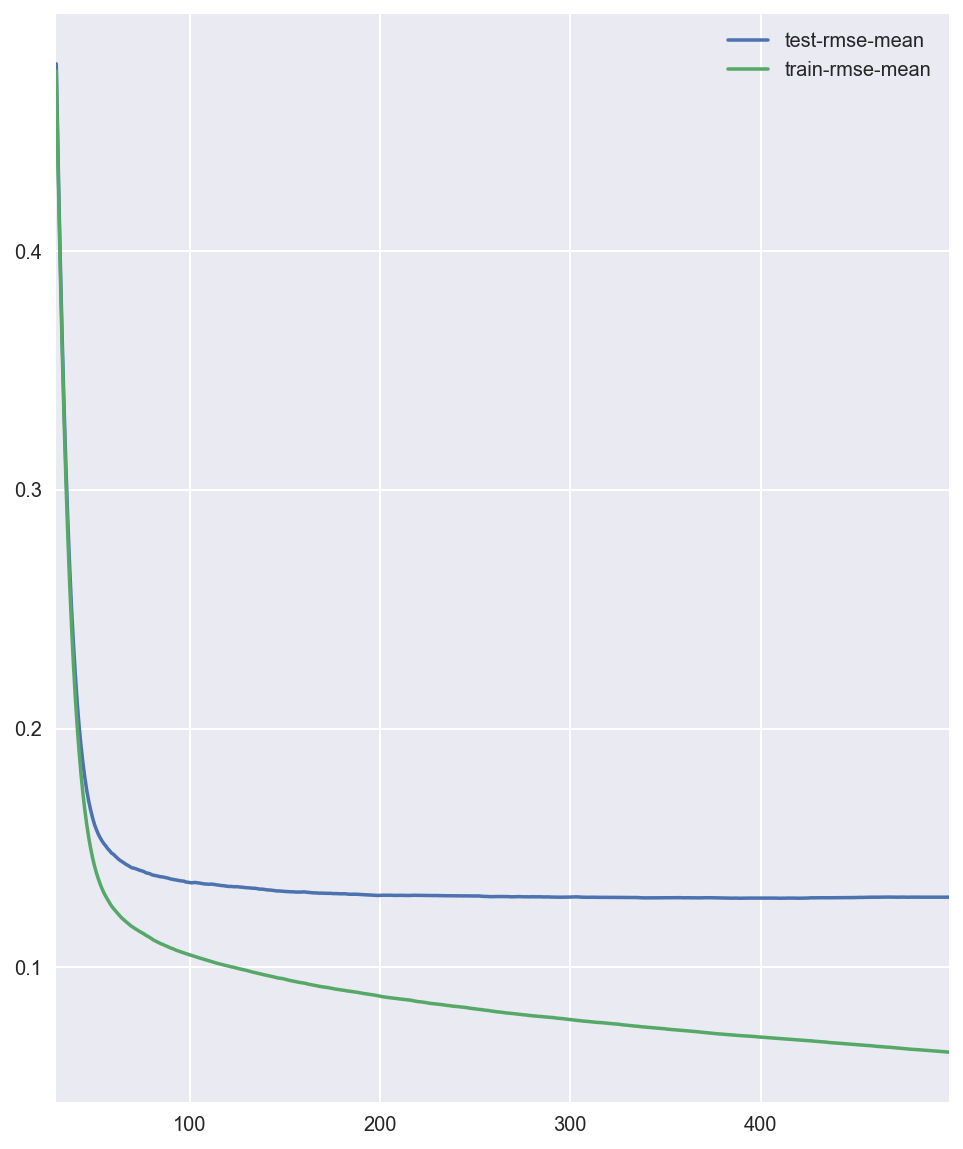

In [124]:
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [125]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(X_train, y)

print("xgb", r2_cv(model_xgb).mean(),  rmse_cv(model_xgb).mean())

xgb 0.895456300702 0.128810079603


In [126]:
xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

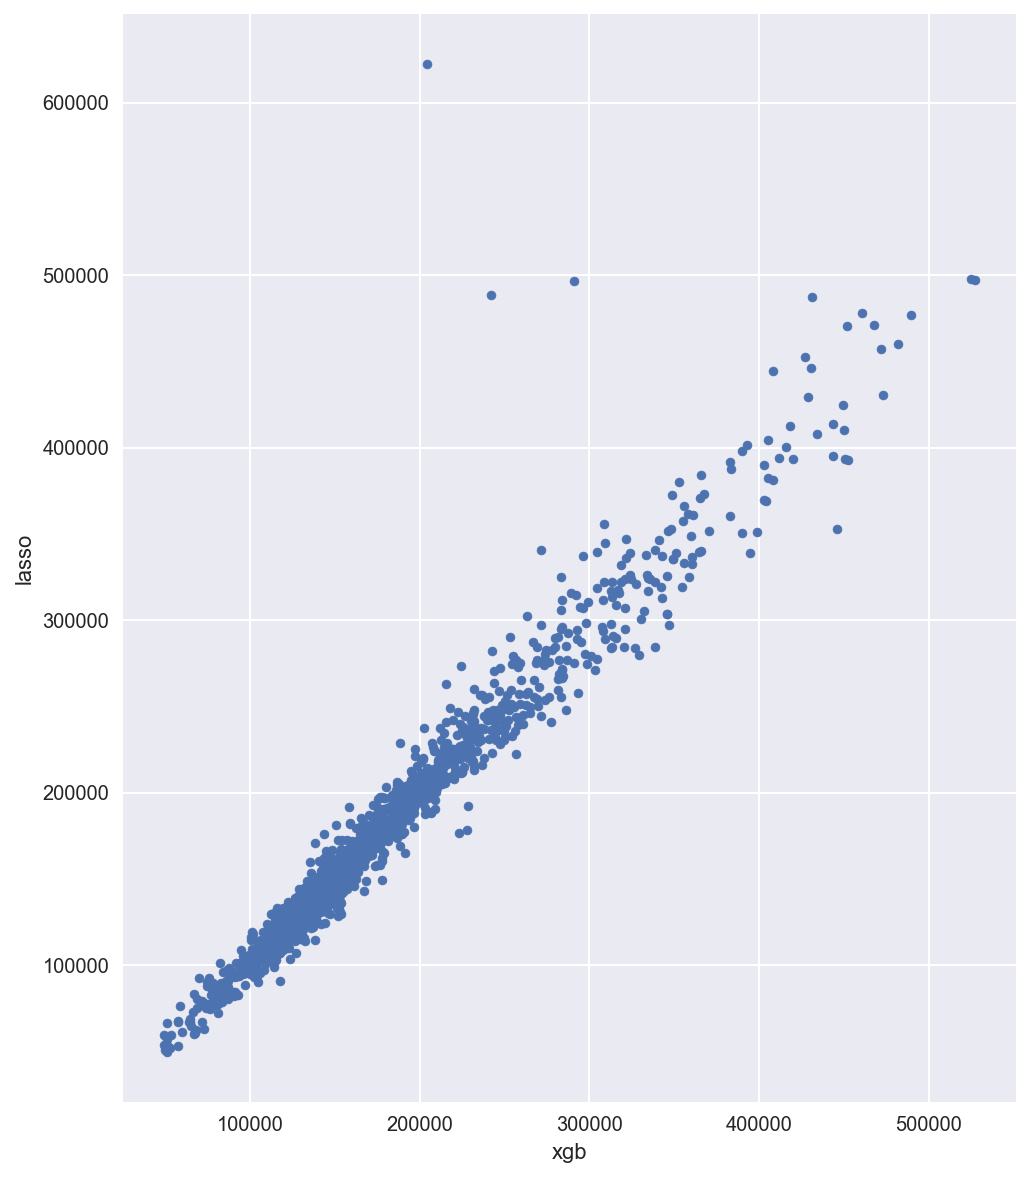

In [127]:
predictions = pd.DataFrame({"xgb":xgb_preds, "lasso":lasso_preds})
predictions.plot(x = "xgb", y = "lasso", kind = "scatter")

Many times it makes sense to take a weighted average of uncorrelated results - this usually imporoves the score although in this case it doesn't help that much.

In [128]:
preds = 0.7*lasso_preds + 0.3*xgb_preds

In [129]:
solution = pd.DataFrame({"id":test.Id, "SalePrice":preds})
solution.to_csv("ridge_sol.csv", index = False)

### Trying out keras?

Feedforward Neural Nets doesn't seem to work well at all...I wonder why.

In [ ]:
from keras.layers import Dense
from keras.models import Sequential
from keras.regularizers import l1
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
X_train = StandardScaler().fit_transform(X_train)

In [ ]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y, random_state = 3)

In [ ]:
X_tr.shape

In [ ]:
X_tr

In [ ]:
model = Sequential()
#model.add(Dense(256, activation="relu", input_dim = X_train.shape[1]))
model.add(Dense(1, input_dim = X_train.shape[1], W_regularizer=l1(0.001)))

model.compile(loss = "mse", optimizer = "adam")

In [ ]:
model.summary()

In [ ]:
hist = model.fit(X_tr, y_tr, validation_data = (X_val, y_val))

In [ ]:
pd.Series(model.predict(X_val)[:,0]).hist()